In [2]:
!python -V

Python 3.9.19


In [3]:
import pandas as pd

import os

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [4]:

import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/zoomcamp_practices/02-experiment_tracking/mlruns/1', creation_time=1717047875965, experiment_id='1', last_update_time=1717047875965, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [17]:
#os.makedirs('models', exist_ok=True)

In [5]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_6036/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')


/tmp/ipykernel_6036/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


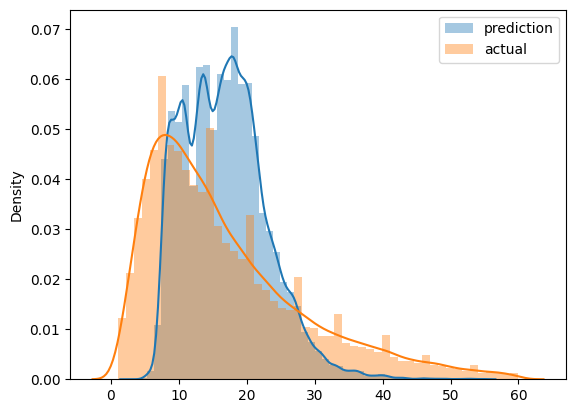

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [30]:
 # Ensure the directory exists
artifact_dir = "model_artifacts"
if not os.path.exists(artifact_dir):
    os.makedirs(artifact_dir)

In [31]:
with mlflow.start_run():

    mlflow.set_tag("developer", "folu")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path = "models/lin_reg.bin", artifact_path = artifact_dir)

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
import mlflow

In [18]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope


In [19]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared = False)
        mlflow.log_metric("rmse", rmse)

    return {"loss" : rmse, "status" : STATUS_OK}



In [21]:
search_space = {
    "max_depth" : scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate" : hp.loguniform("learning_rate", -3, 0),
    "reg_alpha" : hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda" : hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight" : hp.loguniform("min_child_weight", -1, 3),
    "objective" : "reg:linear",
    "seed" : 42,
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:57:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78599                           
[1]	validation-rmse:7.40075                           
[2]	validation-rmse:6.87657                           
[3]	validation-rmse:6.67344                           
[4]	validation-rmse:6.57588                           
[5]	validation-rmse:6.52950                           
[6]	validation-rmse:6.50740                           
[7]	validation-rmse:6.48844                           
[8]	validation-rmse:6.47599                           
[9]	validation-rmse:6.46443                           
[10]	validation-rmse:6.45950                          
[11]	validation-rmse:6.45541                          
[12]	validation-rmse:6.45064                          
[13]	validation-rmse:6.44777                          
[14]	validation-rmse:6.44478                          
[15]	validation-rmse:6.44346                          
[16]	validation-rmse:6.43883                          
[17]	validation-rmse:6.43797                          
[18]	valid

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:57:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.82542                                                    
[1]	validation-rmse:6.69015                                                    
[2]	validation-rmse:6.68207                                                    
[3]	validation-rmse:6.67425                                                    
[4]	validation-rmse:6.66757                                                    
[5]	validation-rmse:6.66432                                                    
[6]	validation-rmse:6.65696                                                    
[7]	validation-rmse:6.64975                                                    
[8]	validation-rmse:6.63913                                                    
[9]	validation-rmse:6.63357                                                    
[10]	validation-rmse:6.62690                                                   
[11]	validation-rmse:6.62211                                                   
[12]	validation-rmse:6.62225            

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:58:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35924                                                   
[1]	validation-rmse:10.62519                                                   
[2]	validation-rmse:9.99943                                                    
[3]	validation-rmse:9.46705                                                    
[4]	validation-rmse:9.01672                                                    
[5]	validation-rmse:8.63820                                                    
[6]	validation-rmse:8.31998                                                    
[7]	validation-rmse:8.05338                                                    
[8]	validation-rmse:7.82964                                                    
[9]	validation-rmse:7.64409                                                    
[10]	validation-rmse:7.48985                                                   
[11]	validation-rmse:7.36174                                                   
[12]	validation-rmse:7.25470            

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:58:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39888                                                    
[1]	validation-rmse:7.20515                                                    
[2]	validation-rmse:6.85830                                                    
[3]	validation-rmse:6.73796                                                    
[4]	validation-rmse:6.68869                                                    
[5]	validation-rmse:6.66411                                                    
[6]	validation-rmse:6.65078                                                    
[7]	validation-rmse:6.64212                                                    
[8]	validation-rmse:6.63836                                                    
[9]	validation-rmse:6.63255                                                    
[10]	validation-rmse:6.62941                                                   
[11]	validation-rmse:6.62758                                                   
[12]	validation-rmse:6.62510            

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:59:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.98626                                                    
[1]	validation-rmse:6.64011                                                    
[2]	validation-rmse:6.58346                                                    
[3]	validation-rmse:6.56832                                                    
[4]	validation-rmse:6.55945                                                    
[5]	validation-rmse:6.55127                                                    
[6]	validation-rmse:6.54506                                                    
[7]	validation-rmse:6.53697                                                    
[8]	validation-rmse:6.52788                                                    
[9]	validation-rmse:6.52220                                                    
[10]	validation-rmse:6.51725                                                   
[11]	validation-rmse:6.50927                                                   
[12]	validation-rmse:6.50518            

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:00:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.57387                                                   
[1]	validation-rmse:11.00160                                                   
[2]	validation-rmse:10.49057                                                   
[3]	validation-rmse:10.03540                                                   
[4]	validation-rmse:9.63104                                                    
[5]	validation-rmse:9.27262                                                    
[6]	validation-rmse:8.95592                                                    
[7]	validation-rmse:8.67696                                                    
[8]	validation-rmse:8.43165                                                    
[9]	validation-rmse:8.21625                                                    
[10]	validation-rmse:8.02735                                                   
[11]	validation-rmse:7.86228                                                   
[12]	validation-rmse:7.71809            

KeyboardInterrupt: 

In [24]:
 params = {
    "learning_rate" : 0.1162646148253358,
   "max_depth" : 43,
    "min_child_weight" : 1.9947616496609175,
    "objective" : "reg:linear",
    "reg_alpha" : 0.027509254462618673,
    "reg_lambda" : 0.17042846753843005,
    "seed" : 42
 }


mlflow.xgboost.autolog()

booster = xgb.train(
params = params,
dtrain = train,
num_boost_round = 1000,
evals = [(valid, "validation")],
early_stopping_rounds = 50
)

2024/05/30 17:04:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4969442814274ac6a44ba7e038afb08f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:04:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.27737
[1]	validation-rmse:10.48340
[2]	validation-rmse:9.81051
[3]	validation-rmse:9.24725
[4]	validation-rmse:8.77449
[5]	validation-rmse:8.38119
[6]	validation-rmse:8.05689
[7]	validation-rmse:7.78716
[8]	validation-rmse:7.56678
[9]	validation-rmse:7.38647
[10]	validation-rmse:7.23838
[11]	validation-rmse:7.11405
[12]	validation-rmse:7.01292
[13]	validation-rmse:6.92925
[14]	validation-rmse:6.86078
[15]	validation-rmse:6.80252
[16]	validation-rmse:6.75549
[17]	validation-rmse:6.71425
[18]	validation-rmse:6.68087
[19]	validation-rmse:6.65278
[20]	validation-rmse:6.62809
[21]	validation-rmse:6.60650
[22]	validation-rmse:6.58917
[23]	validation-rmse:6.57310
[24]	validation-rmse:6.55977
[25]	validation-rmse:6.54770
[26]	validation-rmse:6.53852
[27]	validation-rmse:6.52978
[28]	validation-rmse:6.52153
[29]	validation-rmse:6.51593
[30]	validation-rmse:6.50976
[31]	validation-rmse:6.50432
[32]	validation-rmse:6.49913
[33]	validation-rmse:6.49492
[34]	validation-rmse:6

2024/05/30 17:07:26 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/30 17:07:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:07:26] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [35]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label = y_train)
    valid = xgb.DMatrix(X_val, label = y_val)

    best_params = {
        "learning_rate" : 0.1162646148253358,
        "max_depth" : 43,
        "min_child_weight" : 1.9947616496609175,
        "objective" : "reg:linear",
        "reg_alpha" : 0.027509254462618673,
        "reg_lambda" : 0.17042846753843005,
        "seed" : 42
    }
     
    mlflow.log_params(best_params)

    booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path= "models_mlflow")

/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:07:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.27737
[1]	validation-rmse:10.48340
[2]	validation-rmse:9.81051
[3]	validation-rmse:9.24725
[4]	validation-rmse:8.77449
[5]	validation-rmse:8.38119
[6]	validation-rmse:8.05689
[7]	validation-rmse:7.78716
[8]	validation-rmse:7.56678
[9]	validation-rmse:7.38647
[10]	validation-rmse:7.23838
[11]	validation-rmse:7.11405
[12]	validation-rmse:7.01292
[13]	validation-rmse:6.92925
[14]	validation-rmse:6.86078
[15]	validation-rmse:6.80252
[16]	validation-rmse:6.75549
[17]	validation-rmse:6.71425
[18]	validation-rmse:6.68087
[19]	validation-rmse:6.65278
[20]	validation-rmse:6.62809
[21]	validation-rmse:6.60650
[22]	validation-rmse:6.58917
[23]	validation-rmse:6.57310
[24]	validation-rmse:6.55977
[25]	validation-rmse:6.54770
[26]	validation-rmse:6.53852
[27]	validation-rmse:6.52978
[28]	validation-rmse:6.52153
[29]	validation-rmse:6.51593
[30]	validation-rmse:6.50976
[31]	validation-rmse:6.50432
[32]	validation-rmse:6.49913
[33]	validation-rmse:6.49492
[34]	validation-rmse:6

2024/05/30 18:10:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [18:10:39] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/30 18:10:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/workspaces/ENTER/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported be

In [37]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [38]:
client.list_experiments()

AttributeError: 'MlflowClient' object has no attribute 'list_experiments'

In [39]:
client.create_experiment(name = "my-cool-experiment")

'2'

In [45]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids = "1",
    filter_string = "metrics.rmse < 6.8", # you cna either leave this as empty strings or filter accoring to a particular treshold
    run_view_type = ViewType.ACTIVE_ONLY,
    max_results = 5,
    order_by = ["metrics.rmse ASC"]
)

In [46]:
for run in runs:
    print(f"run is : {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run is : b00a1abcf1174de1b486c06c702fc04f, rmse: 6.3014
run is : bedd5d7a85be493abbb23b1746cb14d0, rmse: 6.3014
run is : cb50c23e6bc147e7a71a0aea3afe71fa, rmse: 6.3014
run is : 137df9081b4f493bb190923852871834, rmse: 6.3148
run is : fb199f94803a4be598c05a3e10045518, rmse: 6.3292


In [47]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [50]:
run_id = "137df9081b4f493bb190923852871834"
model_uri= f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name = "nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '3' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1717094997518, current_stage='None', description=None, last_updated_timestamp=1717094997518, name='nyc-taxi-regressor', run_id='137df9081b4f493bb190923852871834', run_link=None, source='/workspaces/zoomcamp_practices/02-experiment_tracking/mlruns/1/137df9081b4f493bb190923852871834/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [51]:
model_uri

'runs:/137df9081b4f493bb190923852871834/model'

In [56]:
model_name = "nyc-taxi-regressor"
latest_versions = client.get_latest_versions(name = model_name)

for version in latest_versions:
    print(f"version : {version.version}, stage: {version.current_stage}")

version : 3, stage: None


/tmp/ipykernel_6036/4096842599.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name = model_name)


In [60]:
model_version = 3
new_stage = "staging"

client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions = False
)

/tmp/ipykernel_6036/781345775.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1717094997518, current_stage='Staging', description=None, last_updated_timestamp=1717096109801, name='nyc-taxi-regressor', run_id='137df9081b4f493bb190923852871834', run_link=None, source='/workspaces/zoomcamp_practices/02-experiment_tracking/mlruns/1/137df9081b4f493bb190923852871834/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [62]:
from datetime import datetime

In [64]:
date = datetime.today().date()
client.update_model_version(
    name = model_name,
    version = model_version,
    description = f"The model {model_version} was trasitioned to {new_stage} {date}"
)

<ModelVersion: aliases=[], creation_timestamp=1717094997518, current_stage='Staging', description='The model 3 was trasitioned to staging 2024-05-30', last_updated_timestamp=1717096198515, name='nyc-taxi-regressor', run_id='137df9081b4f493bb190923852871834', run_link=None, source='/workspaces/zoomcamp_practices/02-experiment_tracking/mlruns/1/137df9081b4f493bb190923852871834/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>